### Getting started with feature importance and fairness using ML & SHAP


* We'll look at feature importance according to ML models. 
* We can use multiple methods - e.g. permutation importance, shapley, and the  difference in feature importance from different models

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import shap
import gc

from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
warnings.simplefilter(action='ignore', category=FutureWarning)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/compass/cox-violent-parsed_filt.csv
/kaggle/input/compass/cox-violent-parsed.csv
/kaggle/input/compass/compas-scores-raw.csv
/kaggle/input/compass/propublicaCompassRecividism_data_fairml.csv/._propublica_data_for_fairml.csv
/kaggle/input/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv


In [2]:
# import pandas as pd
# compas_scores_raw = pd.read_csv("../input/compass/compas-scores-raw.csv")
# cox_violent_parsed = pd.read_csv("../input/compass/cox-violent-parsed.csv")
# cox_violent_parsed_filt = pd.read_csv("../input/compass/cox-violent-parsed_filt.csv")

In [3]:
TARGET_COL = "Two_yr_Recidivism"

## We'll start with the naive fairML subset of the data. Very simple
* **Target column**: `Two_yr_Recidivism` = recividism (any) within 2 years
* Note that we have fewer variables and features here.


In [4]:
df = pd.read_csv("../input/compass/propublicaCompassRecividism_data_fairml.csv/propublica_data_for_fairml.csv")

print(df.shape)
display(df.columns)
df.head()

(6172, 12)


Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


In [5]:
data = df.drop([TARGET_COL],axis=1)
y = df[TARGET_COL]

In [6]:
# LightGBM GBDT with KFold or Stratified KFold
# Overkill function below based on : https://www.kaggle.com/hmendonca/lightgbm-predictions-explained-with-shap-0-796
def kfold_lightgbm(train_df, train_target, test_df, num_folds, stratified=False, debug=False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feat_importance = pd.DataFrame()
    scores = []
    models = []
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, train_target)):
        train_x, train_y = train_df.iloc[train_idx], train_target.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], train_target.iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
#             nthread=4,
            #is_unbalance=True,
#             n_estimators=10000,
            learning_rate=0.04,
#             num_leaves=32,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.04,
#             reg_lambda=0.073,
#             min_split_gain=0.0222415,
#             min_child_weight=40,
#             silent=-1,
#             verbose=-1,
            #scale_pos_weight=11
            )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 50)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df, num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        ## feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = test_df.columns.values
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["shap_values"] = abs(shap.TreeExplainer(clf).shap_values(valid_x)[:,:test_df.shape[1]]).mean(axis=0).T
        fold_importance_df["fold"] = n_fold + 1
        feat_importance = pd.concat([feat_importance, fold_importance_df], axis=0)
        
        scores.append(roc_auc_score(valid_y, oof_preds[valid_idx]))
        print('Fold %2d AUC : %.6f' % (n_fold + 1, scores[n_fold]))
        models.append(clf)
        del clf, train_x, train_y, valid_x, valid_y, fold_importance_df
        gc.collect()

    score = roc_auc_score(train_target, oof_preds)
    print('Full AUC score %.6f' % score)
    print('Mean AUC score %.6f' % np.mean(scores))
    # Write submission file and plot feature importance
    if not debug:
        pd.DataFrame(oof_preds).to_csv("lgb{:03}_{:.5f}_train_oof.csv".format(test_df.shape[1], score), index=False)
        sub_df = pd.read_csv('../input/sample_submission.csv')
        sub_df['TARGET'] = sub_preds
        sub_df.to_csv("lgb{:03}_{:.5f}.csv".format(test_df.shape[1], score), index= False)
    display_shapley_values(feat_importance)
    return feat_importance, models, scores

# Display/plot feature importance
def display_importances(feat_importance):
    best_features = feat_importance[["feature", "importance"]].groupby("feature")["importance"].agg(['mean', 'std']) \
                                                              .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean importance", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean importance", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

# Display/plot shapley values
def display_shapley_values(feat_importance):
    best_features = feat_importance[["feature", "shap_values"]].groupby("feature")["shap_values"].agg(['mean', 'std']) \
                                                               .sort_values(by="mean", ascending=False).head(40).reset_index()
    best_features.columns = ["feature", "mean shapley values", "err"]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="mean shapley values", y="feature", xerr=best_features['err'], data=best_features)
    plt.title('LightGBM shapley values (avg over folds)')
    plt.tight_layout()
    plt.show()

In [7]:
# # train_df = df[df['TARGET'].notnull()][feats]
# # train_target = df[df['TARGET'].notnull()]['TARGET']
# # test_df = df[df['TARGET'].isnull()][feats]


# %%time
# feat_importance, models, scores = kfold_lightgbm(train_df, train_target, test_df, num_folds=5, stratified=False, debug=debug)

In [8]:
#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.25, shuffle=True, stratify=y, random_state=42)

## ----------Dataset for  LightGBM Model  -----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [9]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4
}

In [10]:
lgbm = lgb.train(params,
                 train_data,
#                  2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 15,
                 verbose_eval= 30
                 )

Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.73577


In [11]:
y_pred = lgbm.predict(valid_x)
score = roc_auc_score(valid_y, y_pred)
print("Overall AUC on validation (not test!): {:.3f}" .format(score))

Overall AUC on validation (not test!): 0.736


In [12]:
import shap
lgbm.params['objective'] = 'binary' ## workaround
%time shap_values = shap.TreeExplainer(lgbm).shap_values(data)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 458 ms, sys: 18.4 ms, total: 476 ms
Wall time: 330 ms


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


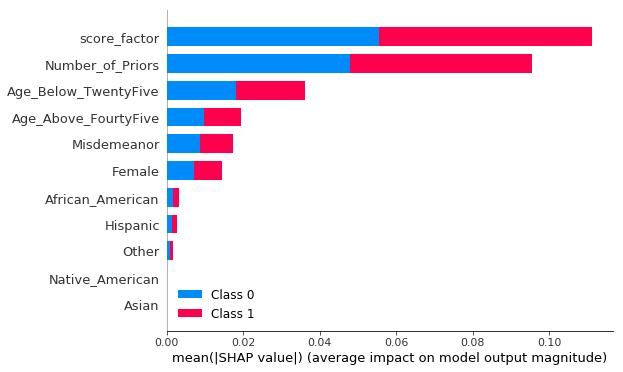

In [13]:
shap.summary_plot(shap_values, data)
# shap values over all the data

* We see that shap gives the most importance to the model score. Followed by # priors and age, then gender. Race has the wekest effect, mainly if the individual is African american. 


* Let's look at some Partial dependency plots over the validation data: (Plot a feature vs another variable. e.g. target =1 ). 

In [14]:
%time shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x)

CPU times: user 231 ms, sys: 63.5 ms, total: 294 ms
Wall time: 78.6 ms


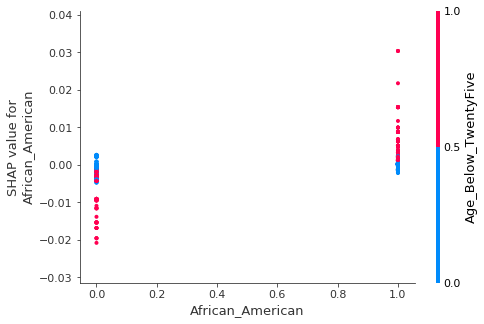

In [15]:
shap.dependence_plot("African_American", shap_values[1], valid_x)
# plot over the validation data

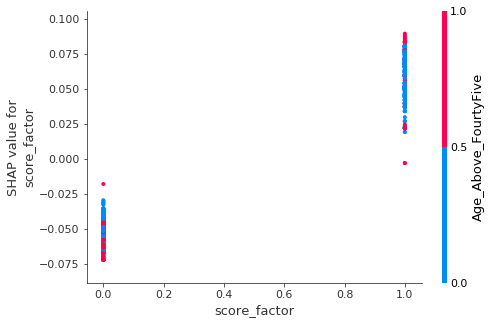

In [16]:
shap.dependence_plot("score_factor", shap_values[1], valid_x)
## we see that the cutoff misses quite a few "outliers" at the 0.5 cutoff. 

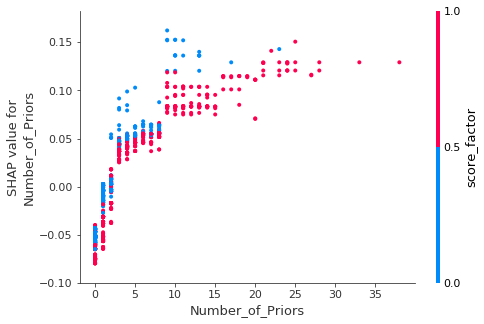

In [17]:
shap.dependence_plot("Number_of_Priors", shap_values[1], valid_x)

## Next steps:
* Try different models
* try different feature importance metrics - e.g. perturbation or naive model importance
* Try the full compass dataset and variables , and different targets (e.g. violent recividism vs any recividism).
* Probe the racial bias. (e.g. FP/TP and the age+gender+priors as counfounders)